# Example 7: Full suite for NW Pacific

Let's take a look now at an oceanic area, where we should be using Free-air gravity anomaly data instead of Bouguer. This example should produce elastic thickness estimates that are very close to those of Kalnins et al. (2009), although we use the parameter F as an additional model parameter (the analysis of Kalnins et al. (2009) is equivalent to setting `F` equal to zero everywhere).

<div class="alert alert-block alert-warning">
<b>Warning:</b> These grids are fairly large and may require too much memory for the wavelet transform calculations. You can try to decimate the data original sets by a factor of two before starting the analysis if you run into memory problems; however, this will change the sampling distance so be extra careful in that case. The estimation of flexural parameters over the whole grid will also be much slower, so make sure to use an appropriate decimating factor for testing.
</div>

In [1]:
import numpy as np
import pandas as pd
from plateflex import TopoGrid, FairGrid, ZcGrid, Project

# Read header (first line) of data set using pandas to get grid parameters
xmin, xmax, ymin, ymax, zmin, zmax, dx, dy, nx, ny = \
pd.read_csv('../data/Bathy_PAC.xyz', sep='\t', nrows=0).columns[1:].values.astype(float)

# Change type of nx and ny from float to integers
nx = int(nx); ny = int(ny)

# Read bathymetry and free-air anomaly data 
bathydata = pd.read_csv('../data/Bathy_PAC.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]
fairdata = pd.read_csv('../data/Freeair_PAC.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# Read crustal thickness data
thickdata = pd.read_csv('../data/crustal_thickness_PAC.xyz', sep='\t', \
    skiprows=1, names=['x', 'y', 'z'])['z'].values.reshape(ny,nx)[::-1]

# # Here we could extract a smaller grid to make things easier to test - power of 2 for faster processing
# bathydata = bathydata[100:356, 100:356]
# fairdata = fairdata[100:356, 100:356]
# thickdata = thickdata[100:356, 100:356]

All those data sets can be imported into their corresponding `Grid` objects:

grid contains NaN values. Performing interpolation...


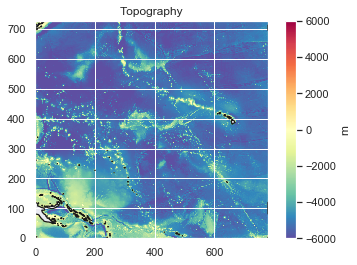

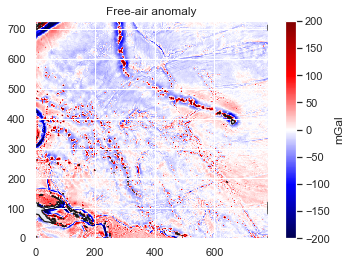

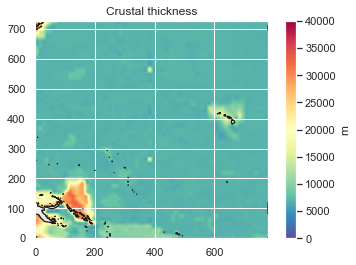

In [2]:
# Load the data as `TopoGrid` and `FairGrid` objects
bathy = TopoGrid(bathydata, dx, dy)
fair = FairGrid(fairdata, dx, dy)

# Create contours
contours = bathy.make_contours(0.)

# Make mask over land areas
mask = (bathy.data > 0.)

# Load the crustal thickness as `ZcGrid` object
thick = ZcGrid(thickdata, dx, dy)

# Plot the three data sets
bathy.plot(mask=mask, contours=contours, cmap='Spectral_r', vmin=-6000, vmax=6000)
fair.plot(mask=mask, contours=contours, cmap='seismic', vmin=-200, vmax=200)
thick.plot(mask=mask, contours=contours, cmap='Spectral_r', vmin=0., vmax=40000)

Filter water depth attribute and plot it

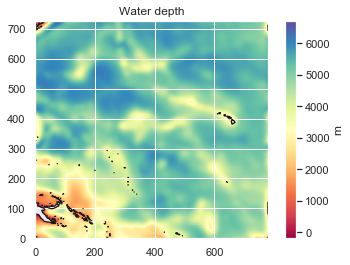

In [3]:
# Produce filtered version of water depth
bathy.filter_water_depth()
bathy.plot_water_depth(mask=mask, contours=contours, cmap='Spectral')

We might want to change the value of crustal density, since it should be higher than 2700 kg/m^3 (default value). However, we don't have a `Grid` object for density, so let's fix a new global value:

In [4]:
# Import plateflex to change default variables
from plateflex.flex import conf_flex
conf_flex.rhoc = 2800.

Define the project with new `Grid` objects, initialize it and execute!

In [5]:
# Define new project
project = Project(grids=[bathy, fair, thick])

# Initialize project
project.init()

# Calculate wavelet admittance and coherence
project.wlet_admit_coh()

# Make sure we are using 'L2'
project.inverse = 'L2'

# Insert mask
project.mask = mask

# Estimate flexural parameters at every 5 points of the initial grid
project.estimate_grid(5, atype='admit')

Computing: [##########] 145/145


Now plot everything

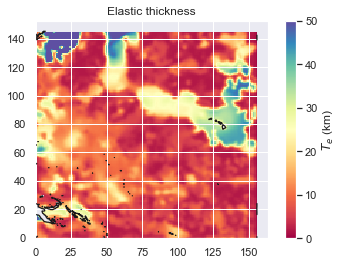

In [6]:
project.plot_results(mean_Te=True, mask=True, contours=contours, cmap='Spectral', vmin=0., vmax=50.)

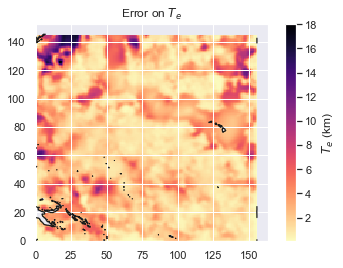

In [7]:
project.plot_results(std_Te=True, mask=True, contours=contours, cmap='magma_r')

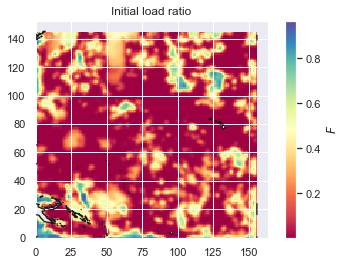

In [8]:
project.plot_results(mean_F=True, mask=True, contours=contours, cmap='Spectral')

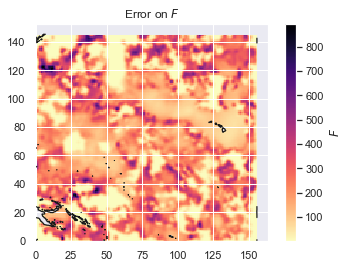

In [9]:
project.plot_results(std_F=True, mask=True, contours=contours, cmap='magma_r')

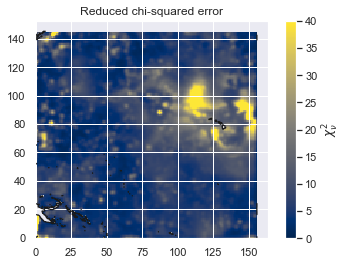

In [10]:
project.plot_results(chi2=True, mask=True, contours=contours, cmap='cividis', vmin=0, vmax=40)

These results are fairly similar to those of Kalnins et al. (2009), with some differences that can partly be attributed to the use of an additional model parameter (`F`). Furthermore, Kalnins et al. (2009) select portions of the admittance function during fitting (based on coherence values greater than 0.4), so additional discrepancies are expected.

You can try again with `atype='coh'` to test the effect of using the coherence function with free-air anomaly data over the ocean. After that you could try one more time with `atype='joint'`.